In [1]:
import config, src
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.utils.class_weight import compute_class_weight

In [2]:
data = src.load_data(config.PROCESSED_DATA_COMBINED_RAP_HIPHOP_FILE)

X_train, X_test, y_train, y_test = src.split_data(data, target_column='music_genre')

class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight = dict(zip(np.unique(y_train), class_weight))

Données chargées avec succès.


In [3]:
lr_classifier = LR(random_state=0, class_weight=class_weight, multi_class="multinomial")
lr_classifier.fit(X_train, y_train)

c:\Users\issam\OneDrive\Documents\cours\M2 ISDS\apprentissage stat\music-genre-prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\issam\OneDrive\Documents\cours\M2 ISDS\apprentissage stat\music-genre-prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={np.int64(0): np.float64(1.11333778668448),
                                 np.int64(1): np.float64(1.120636521544237),
                                 np.int64(2): np.float64(1.116975231074251),
                                 np.int64(3): np.float64(1.0987501716797143),
                                 np.int64(4): np.float64(1.107235785860599),
                                 np.int64(5): np.float64(1.113616748795902),
                                 np.int64(6): np.float64(1.1069600110696),
                                 np.int64(7): np.float64(0.557297109021247),
                                 np.int64(8): np.float64(1.104758748308338)},
                   multi_class='multinomial', random_state=0)

----------------------------------------------------------------------------------------------------

Global accuracy : 0.3549
Global log loss : 1.6814108012518918
Global precision : 0.35605940312977835
Global recall : 0.34803104525507145
Global F1 score : 0.3354188129930412
Global ROC-AUC score : 0.7939369885232205

              Precision    Recall  F1 score
Alternative   0.222494  0.180556  0.199343
Anime         0.495058  0.581238  0.534698
Blues         0.448276  0.089128  0.148693
Classical     0.548642  0.655497  0.597328
Country       0.217651  0.295132  0.250538
Electronic    0.289931  0.331021  0.309116
Jazz          0.286015  0.276142  0.280992
Rap/Hip-Hop   0.494253  0.424691  0.456839
Rock          0.202216  0.298874  0.241223

----------------------------------------------------------------------------------------------------


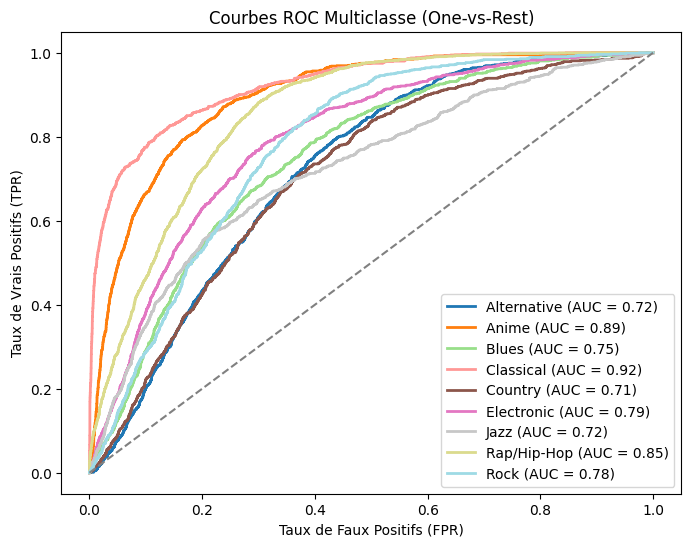

----------------------------------------------------------------------------------------------------


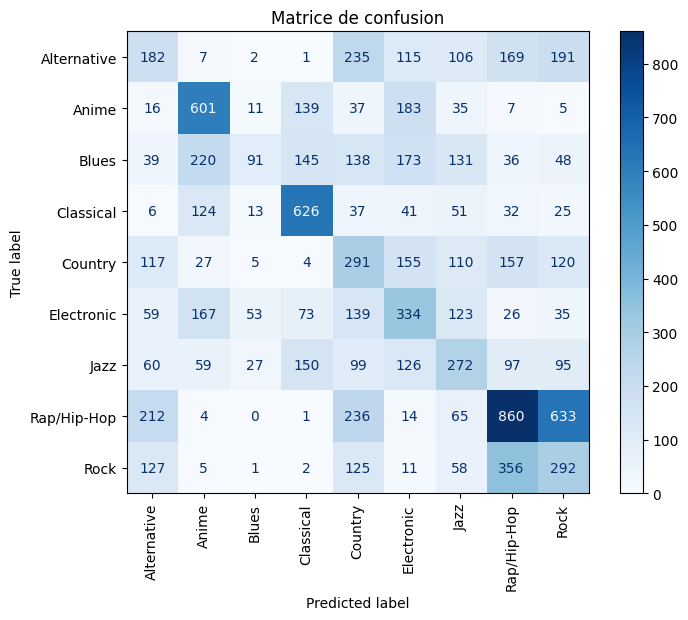

----------------------------------------------------------------------------------------------------


In [4]:
src.evaluate_model(lr_classifier, X_test, y_test, classes=config.CLASSES_COMBINED_RAP_HIPHOP)

Voyons quelles variables sont les plus utiles à la prédiction:

In [5]:
accuracy_variable = {}
for variables in X_train.columns:
    clf = LR(multi_class="multinomial",n_jobs=-1).fit(X_train[variables].to_numpy().reshape(-1, 1), y_train)
    y_pred = clf.predict(X_test[variables].to_numpy().reshape(-1, 1))
    accuracy_variable[variables] = accuracy_score(y_test, y_pred)

print(accuracy_variable)

c:\Users\issam\OneDrive\Documents\cours\M2 ISDS\apprentissage stat\music-genre-prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NameError: name 'accuracy_score' is not defined

Utilisons un algorithme de réduction de dimension pour augmenter le scoring:

In [ ]:
from sklearn.feature_selection import RFE

# Initialize a model and RFE
model = LR(multi_class="multinomial",n_jobs=-1).fit(X, y)
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit RFE to the data
X_reduced = rfe.fit_transform(X, y)
print("Selected Features:", X.columns[rfe.support_])

Nouvelle regression après réduction de dimension, on a un gain de précision de 0.17:

In [ ]:
X_=X.loc[:,rfe.support_]

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, stratify=y)
clf = LR(multi_class="multinomial",n_jobs=-1).fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

Nous utilisons un gread search pour optimiser les paramètres "l1", "l2" et "elastic_net":

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1','l2', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'l1_ratio' : [0,0.01,1]
}


model = LR(multi_class="multinomial",n_jobs=-1)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)


On a donc une amélioration de 0.01 négligeable:

In [ ]:
print("Best Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))